# Taller de ✨🔍redes convolucionales🔍✨

### En este caso, vamos a entrenar una red convolucional usando Keras para analizar imágenes del corpus CIFAR-10

Pero antes que nada, importamos todo lo necesario para poder trabajar

In [ ]:
import numpy as np
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout
from keras.layers import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from keras.layers import Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau as LRS

Definimos aquí los hiperparámetros de la red:

In [ ]:
batch_size = 256
num_classes = 10
epochs = 100

Y aquí nos descargamos el dataset que vamos a utilizar. En este caso, como hemos comentado, vamos a utilizar CIFAR-10, un corpus de imágenes de 10 clases (avión, coche, pájaro, gato, ciervo, perro, rana, caballo, barco y camión) a color en una resolución de 32x32.

Una vez obtenemos el dataset, aplicamos el mismo tratamiento que en el caso de MNIST:
- Codificamos los números a floats de 32 bits para que sean más manejables por la red y los dividimos entre 255 para escalarlos a valores entre 0 y 1.
- Convertimos las etiquetas (numéricas) a una representación interna de Keras para poder trabajar más cómodamente

En el caso de CIFAR-10, las imágenes ya vienen en formato matriz, por lo que no es necesario reconstruirlas.

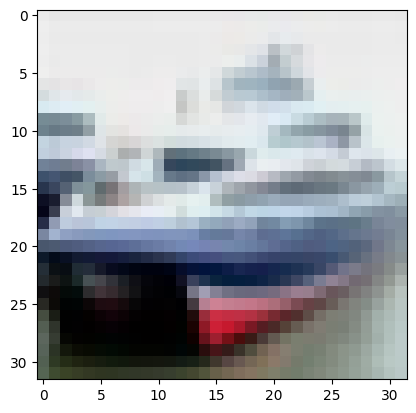

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

def show_img(img):
  import matplotlib.pyplot as plt

  img = np.array(img)
  plt.imshow(img, cmap= 'gray')

x_train /= 255
x_test /= 255

show_img(x_test[1])

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

En esta celda preparamos un "data generator". Este objeto sirve para aplicar transformaciones y perturbaciones a las imágenes del dataset (rotaciones, traslaciones, zoom...). Os lo dejo preparado para que investiguéis con el data augmentation, que si no la red no aprenderá bién.

In [ ]:
data_generator = ImageDataGenerator(
)

Definimos una función que implemente un "bloque convolucional". La función base que he dejado preparada implementa un bloque convolucional con dos convoluciones, batch norm, gaussian noise y dropout tras cada una de ellas, y un max pooling al final. Para experimentar, recomiendo simplemente cambiar el número de convoluciones dentro del bloque (1, 3, 4...). OJO: No necesariamente todos los bloques convolucionales de una red deben tener el mismo número de convoluciones.

In [ ]:
def CBGN(model, filters, ishape=0):
  if ishape:
    model.add(Conv2D(filters, (3,3), padding='same', input_shape=ishape))
  else:
    model.add(Conv2D(filters, (3,3), padding='same'))

  model.add(BN())
  model.add(GN(0.3))
  model.add(Dropout(0.2))
  model.add(Activation('relu'))

  return model
    

Definimos aquí la topología de nuestra red. En el caso base, se ha implementado una red convolucional con cuatro bloques convolucionales que van reduciendo el tamaño de la imágen, pero aumentando el número de canales que tiene (filtros), todo seguido de dos capas densas que sirven de clasificador.

Por ejemplo, en el primer bloque pasaríamos de una imagen 32x32 a 3 canales (RGB) a una imagen 16x16 con 64 canales.

Mi recomendación para la experimentación sería investigar arquitecturas "famosas" y simples de implementar (VGG-16, AlexNet...)

In [ ]:
model = Sequential()

model = CBGN(model, 64, ishape=x_train.shape[1:])
model = CBGN(model, 128)
model = CBGN(model, 256)
model = CBGN(model, 512)

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Aquí definimos el optimizador que vamos a utilizar (en este caso, Adam) y compilamos el modelo con la función de pérdida, optimizador a usar y las métricas que se han de mostrar en tiempo de entrenamiento.

In [ ]:
adam=Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

Definimos ciertas funciones que se utilizan como "callbacks". En este caso, hemos optado por:
- Early stopping, para parar el entrenamiento de nuestro modelo cuando no mejoremos los resultados de forma significativa durante un número de épocas dado.
- Model checkpoint, para guardarnos el checkpoint del estado del modelo que mejores resultados ha ofrecido.
- Learning rate scheduler. En este caso, no hemos definido una función custom, sinó que hemos utilizado "Reduce on plateau" para reducir el factor de aprendizaje cuando nuestra función de pérdida encuentre un "plano".

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=125, min_delta=0.001, monitor='val_accuracy', restore_best_weights=True)
save_best = keras.callbacks.ModelCheckpoint('best.hdf5', save_best_only=True, monitor='val_accuracy')
scheduler = LRS(monitor='val_loss', factor=0.1, patience=15, min_delta=0.005)

callbacks = [early_stopping, save_best, scheduler]

Ahora ya por fin, entrenamos el modelo que hemos preparado y sacamos los resultados por pantalla.

In [ ]:
history = model.fit(data_generator.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
                    steps_per_epoch=len(x_train) / batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks,
                    verbose=1)

scores = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

Finalmente, graficamos las estadísticas del entrenamiento.

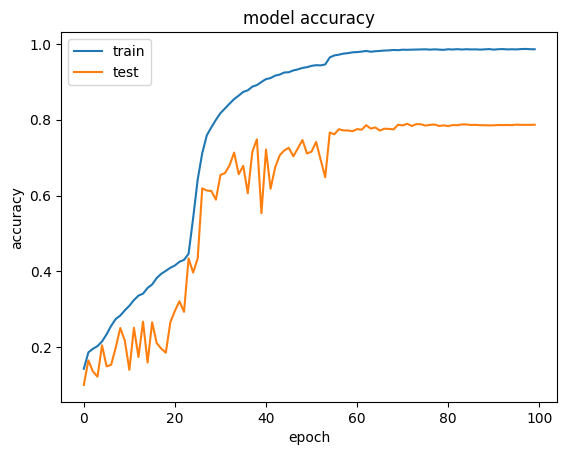

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Como podemos ver, el mayor problema con el que nos encontramos es que la tasa de aciertos en el conjunto de test está muy por debajo de la de el conjunto de train.

Para mitigar esto un poco, e inluso para poder invertir esta tendencia, es muy conveniente jugar con el data augmentation, añadiendo transformaciones a las imágenes de entrenamiento, de forma que el modelo aprenda a generalizar más. Otra opción es experimentar con otras topologías (conocidas, o por conocer).

Mi record en esta tarea ha sido de 0.921 de acierto. Ánimo :)